# Supplementary Project

Participants: 
1. Mohammad Naseri (810100486)
2. Javad Soleimani (810199190)

## Import Libraries

In [58]:
# Tools
import scipy.io as sio
import numpy as np 
import pandas as pd
from tqdm import tqdm
import seaborn as sns; sns.set()
from numpy.random import seed
from numpy.random import randint

# Classification
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

# Feature Extraction
from scipy import stats

# Visualiation
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline, BSpline
import matplotlib.pyplot as plt

## Load Data

In [59]:
mat1 = sio.loadmat('S2T2B1.mat')['a']
mat2= sio.loadmat('S2T2B2.mat')['a']
merged_mat = np.concatenate([mat1, mat2])
merged_mat.shape

(90, 126, 3500)

## Feature Extraction Class

In [60]:
class features:
    def __init__(self, x):
        self.x = x
    
        self.mean = np.mean(x, axis=-1)
        self.std = np.std(x, axis=-1)
        self.ptp = np.ptp(x, axis=-1)
        self.var = np.var(x, axis=-1)
        self.minim = np.min(x, axis=-1)
        self.maxim = np.max(x, axis=-1)
        self.argminim = np.argmin(x, axis=-1)
        self.argmaxim = np.argmax(x, axis=-1)
        self.rms = np.sqrt(np.mean(x**2, axis=-1))
        self.abs_diff_signal = np.sum(np.abs(np.diff(x, axis=-1)), axis=-1)
        self.skewness = stats.skew(x, axis=-1)
        self.kurtosis = stats.kurtosis(x, axis=-1)

## Extract Features from Dataset

In [61]:
features_names = ["mean", "std", "ptp", "var",
                 "minim", "maxim", "argminim", "argmaxim",
                 "rms","abs_diff_signal","skewness","kurtosis"]

interval_length = 50
interval_count = int(3500/interval_length)

# initializing data
data = np.zeros((90, interval_count, len(features_names)*126))

# iterating over trials
for trial in tqdm(range(data.shape[0])):
    # iterating over intervals
    for idx in range(interval_count):
        tmp = features(merged_mat[trial, :, idx*interval_length:(idx+1)*interval_length])
        # extract features
        for i, feature in enumerate(features_names):
            feat_vec = getattr(tmp, feature)
            data[trial, idx, i*126:(i+1)*126] = feat_vec

y = np.array([0 if i < 45 else 1 for i in range(90)])

100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:09<00:00,  9.06it/s]


In [62]:
print('Data Shape: ', data.shape)
print('1512 / 126 =', int(1512/126), '= len(feature_names)')

Data Shape:  (90, 70, 1512)
1512 / 126 = 12 = len(feature_names)


In [63]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [64]:
# seed random number generator
seed(42)
# generate some integers
states = randint(0, 100, 100)
states

array([51, 92, 14, 71, 60, 20, 82, 86, 74, 74, 87, 99, 23,  2, 21, 52,  1,
       87, 29, 37,  1, 63, 59, 20, 32, 75, 57, 21, 88, 48, 90, 58, 41, 91,
       59, 79, 14, 61, 61, 46, 61, 50, 54, 63,  2, 50,  6, 20, 72, 38, 17,
        3, 88, 59, 13,  8, 89, 52,  1, 83, 91, 59, 70, 43,  7, 46, 34, 77,
       80, 35, 49,  3,  1,  5, 53,  3, 53, 92, 62, 17, 89, 43, 33, 73, 61,
       99, 13, 94, 47, 14, 71, 77, 86, 61, 39, 84, 79, 81, 52, 23])

## Classification and Visualization

100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.55it/s]


means shape:  70
std shape:  70


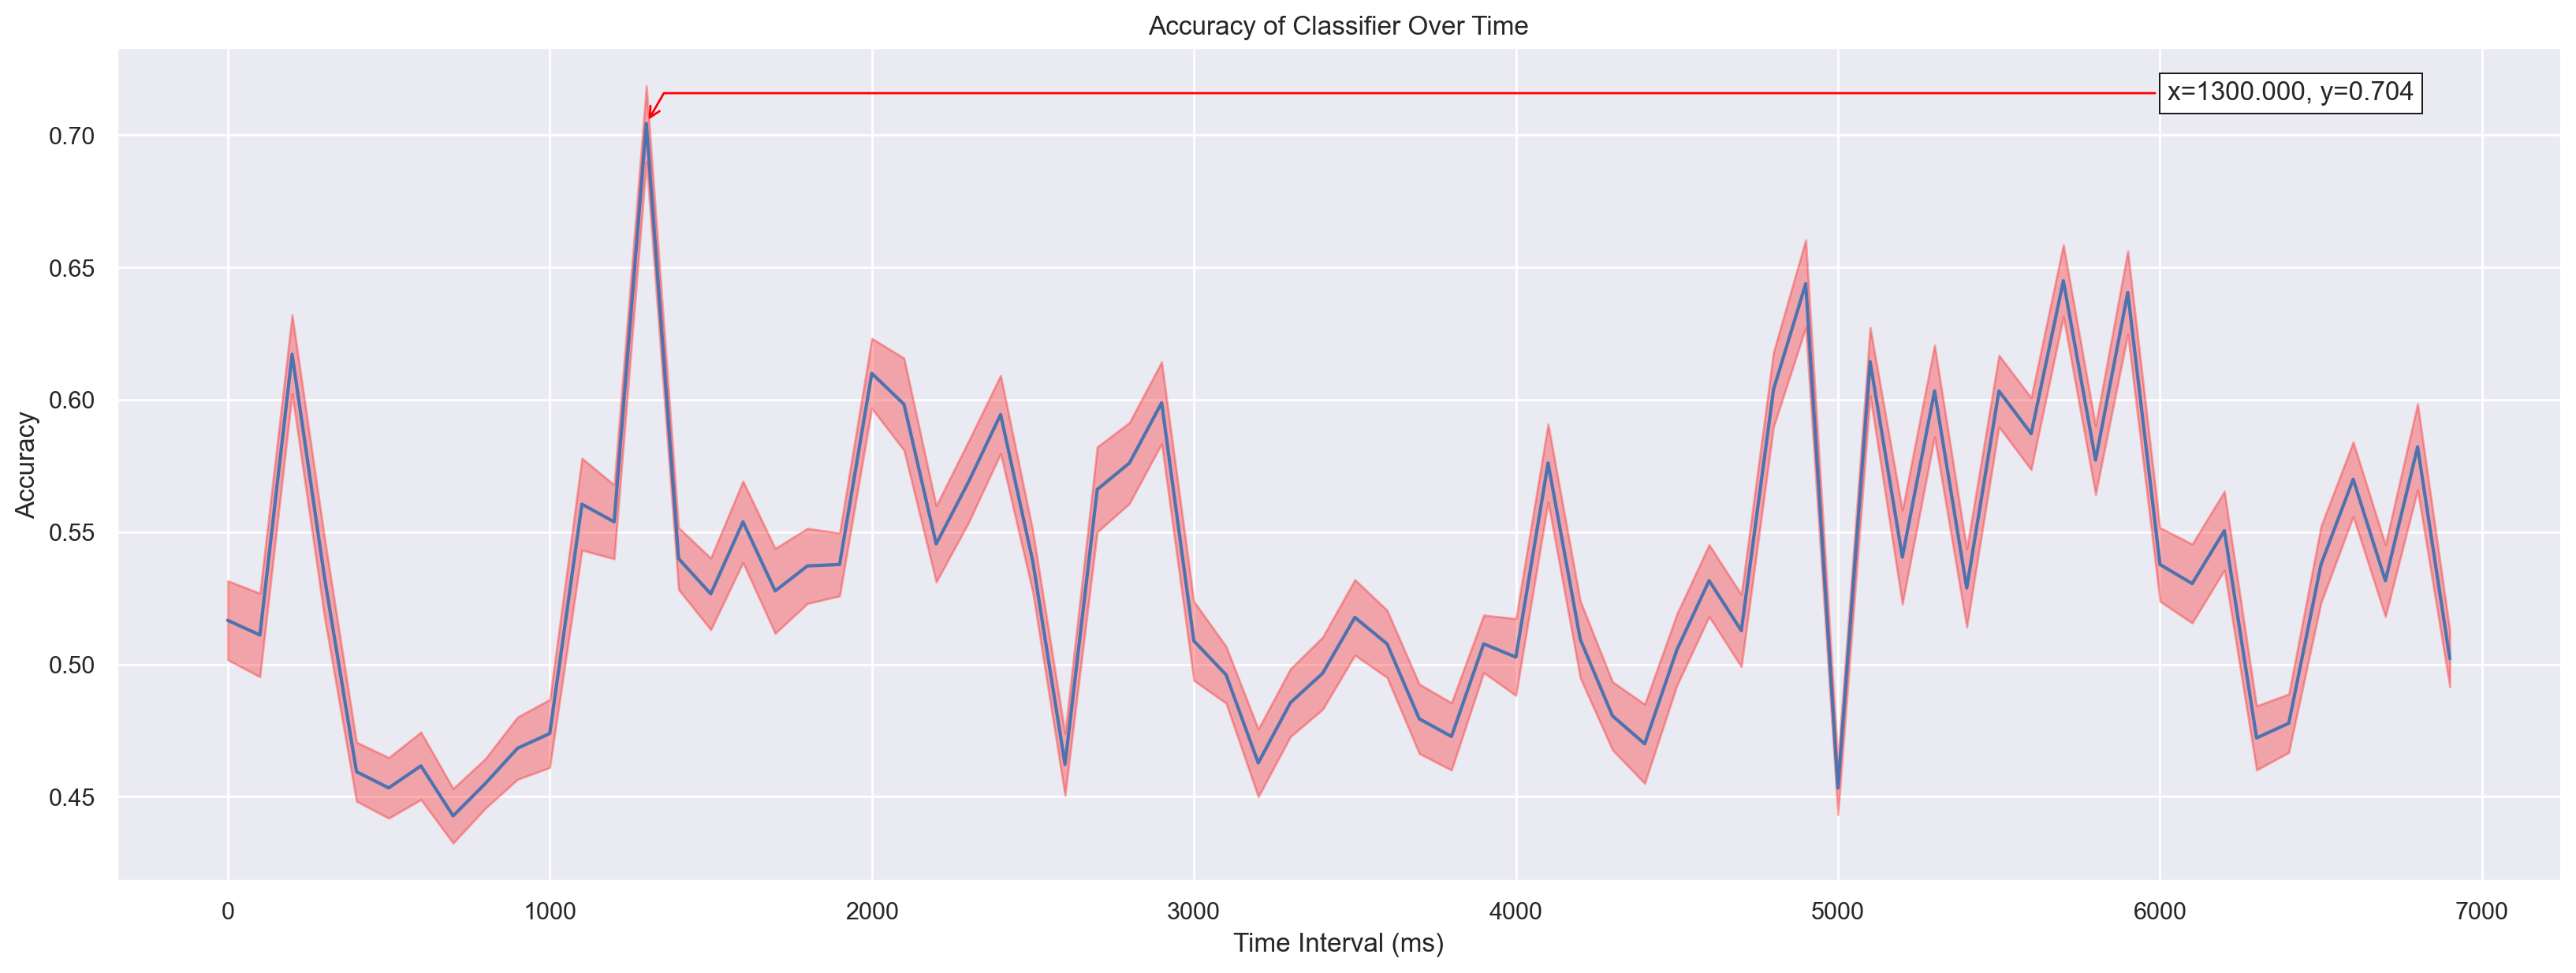

In [123]:
# initializing
mean_acc_arr = []
se_acc_arr = []

# try classifying n times with diffrent random seeds
n = 100

# looping over time interval
for interval in tqdm(range(70)):

    # select the interval and scale it
    X = scale(data[:, interval, :])

    # data dimension reduction using pca to 20 features
    X_pca = PCA(20).fit_transform(X)
    
    tmp_arr = []
    for k in range(n):
        # split data to train/test
        X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, shuffle=True, random_state=states[k])
        # use svm to classify
        clf = SVC(C=20, gamma=0.0175, kernel='rbf').fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        tmp_arr.append(accuracy_score(y_test, y_pred))

    mean_acc_arr.append(np.array(tmp_arr).mean())
    se_acc_arr.append(np.array(tmp_arr).std() / 10)

print('means shape: ', len(mean_acc_arr))
print('std shape: ', len(se_acc_arr))
    
y1 = np.subtract(np.array(mean_acc_arr), np.array(se_acc_arr))
y2 = np.add(np.array(mean_acc_arr), np.array(se_acc_arr))

plt.figure(figsize=(20, 7), dpi=200)

x = range(0, 7000, 100)

plt.plot(x, mean_acc_arr)

plt.fill_between(x, y1, y2, alpha=.3, linewidth=1, color='red')

def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60", color='red')
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

annot_max(x, np.array(mean_acc_arr))

plt.xlabel("Time Interval (ms)")
plt.ylabel("Accuracy")
plt.title("Accuracy of Classifier Over Time")
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x1d60119c3a0>,
 'caps': [<matplotlib.lines.Line2D at 0x1d601184940>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d60119c850>],
 'medians': [<matplotlib.lines.Line2D at 0x1d6011842b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1d60106d610>],
 'means': []}

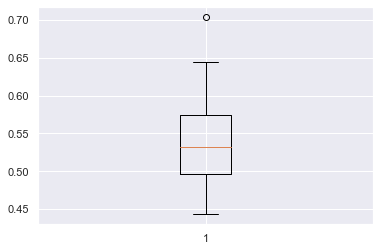

In [124]:
plt.boxplot(mean_acc_arr)

The End ... ! :)